In [1314]:
#                                               CONCEITO:

#Modelo GLM derivam do modelo GLMM, portanto qualquer modelo GLM pode ser implantado no GLMM caso tenha niveis
#Efeitos Fixos = v0j = variancia do intercpto do alpha ou B0 (Interaçao entre variaveis entre os niveis)
#Efeitos Aleatorios = v1j = variancia na inclinaçao do beta
# W é uma variável preditora contextual (grupos contextuais j)(nivel 2)
#v0 e v1 representam, respectivamente, os termos aleatórios de intercepto e inclinação de nível 2
#Se v0j ou v1j  for estatisticamente diferente de 0 Aplicar modelo Multinivel     
#Captura o comportamento Heterocedastico(Efitos Aleatorios) e Multiolineares(Efeitos Fixos) das variaveis
#Caso nao tenho grupos definidos para analise multinivel , pode fazer uma analise de cluster para encontrar os grupos
# E(erro) representa os termos de erro idiossincráticos (nível 1).
#HLM2 = Modelo com 2 Multiniveis

#Nao existe Stepwise para extrair parametros nos modelos Multiniveis

#                                              CRITERIO:

#TIPO DE DISTRIBUIÇAO:

#A Variavel no 2° nivel precisa ter + de 2 obsevaçoes diferentes (pois nao vai  conseguir captar a variancia daqula variavel)
#Variaveis dummies so mudam o intercpto, nao leva em consideraçao a inclinaçao da reta
#inserção de dummies de grupo não torna possível a identificação dos efeitos contextuais, visto que não se separam os efeitos observáveis dos não observáveis sobre a variável dependente.


#                                              APLICAÇOES

In [1315]:
import multilevel_py
import seaborn as sns
import pandas as pd
import numpy as np

In [1316]:
# Carregando o dataset
dados = pd.read_csv('estudante_escola.csv',encoding='latin1',sep=',')
x = dados[['estudante','escola','horas','texp']]
y = dados.desempenho
dados.head(1)

,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6


In [1317]:
# Estatistica descritivas(VAr numericas)
dados[['desempenho','horas','texp']].describe()

,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


In [1319]:
# Estatistica descritivas(VAr Categoricas)
dados['escola'].value_counts(ascending=False)

5     48
3     48
1     47
9     44
8     35
10    33
6     30
7     28
2     25
4     20
Name: escola, dtype: int64

In [1320]:
#Desempenho médio dos estudantes por escola
aa= pd.DataFrame(dados.groupby('escola').desempenho.mean());aa

,desempenho
escola,
1,36.765957
2,21.400000
3,67.125000
4,55.325000
5,19.270833
6,33.966667
7,57.532143
8,75.428571
9,18.556818


**PERGUNTA: Qual a razao da escola 8 esta com uma media boa no desempenho dos alunos? e a escola 9 esta com uma media ruim?será a variavel ('texp'=tempo de experiencia dos professores) tem influencia nesta nota? sera que a variavel ('horas')tem influencia?** 

# Analise Exploratoria

### Escola X Desempenho

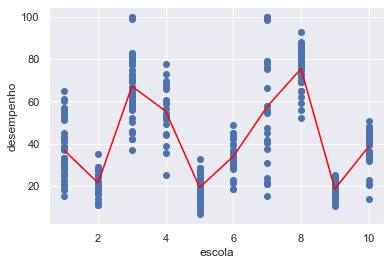

In [1321]:
#Exploração visual do desempenho médio
import matplotlib.pyplot as plt
plt.scatter(dados.escola, dados.desempenho)
plt.plot(aa.desempenho,c='red')
plt.xlabel('escola')
plt.ylabel('desempenho')
plt.show()


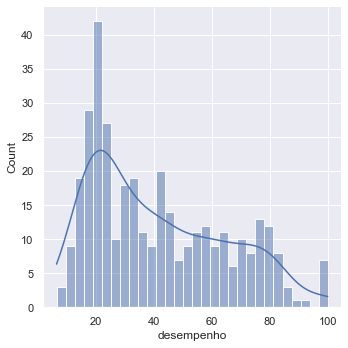

In [1322]:
#Kernel density estimation (KDE) - função densidade de probabilidade da
#variável dependente (desempenho), com histograma
import seaborn as sns
sns.displot(dados.desempenho,kde=True,bins=30)

<AxesSubplot:xlabel='desempenho', ylabel='Density'>

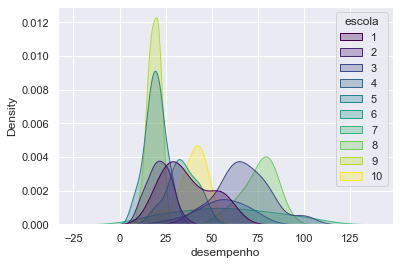

In [1310]:
#Kernel density estimation (KDE) - função densidade de probabilidade da
#variável dependente (desempenho) por escola
sns.kdeplot(data=dados, x="desempenho", hue="escola",fill='escola',palette="viridis",alpha=.3)

<AxesSubplot:xlabel='desempenho', ylabel='Count'>

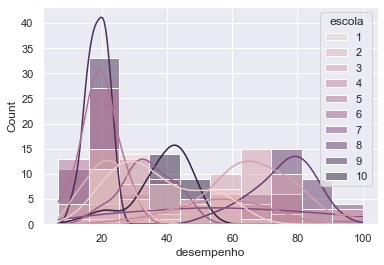

In [1244]:
sns.histplot(x="desempenho", hue="escola",data=dados,kde=True)

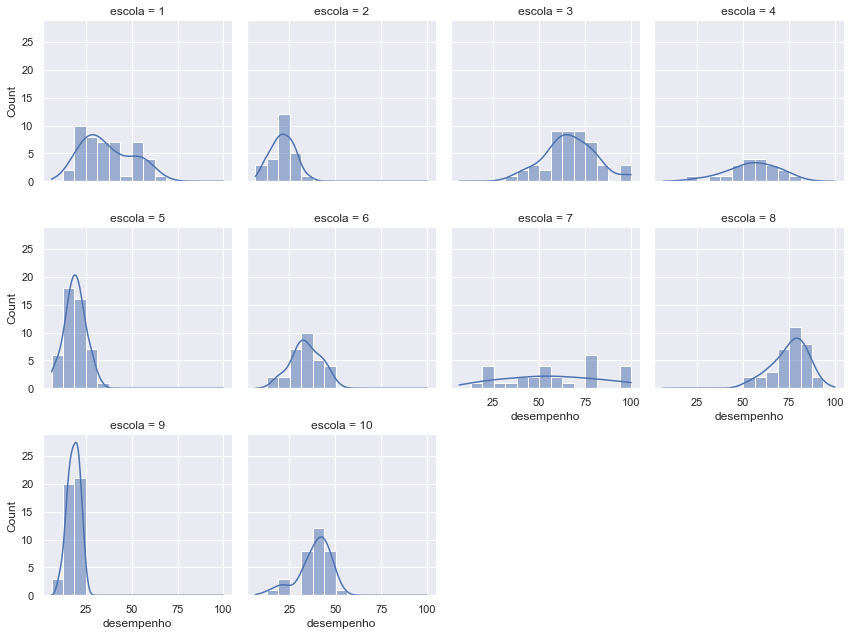

In [1245]:
sns.displot(dados, x="desempenho", col="escola",kde=True,bins=15,col_wrap=4, height=3)


**Nota-se que as escolas 2, 5 e 9 tem os piores desempenhos**

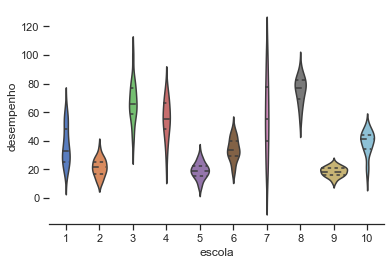

In [1323]:
#Distribuição dos dados
sns.set(style="ticks", palette="muted", color_codes=True)
plt.figure()
sns.violinplot(y=y, x=x.escola, data=dados, split=True,inner="quart")
sns.despine(left=True)

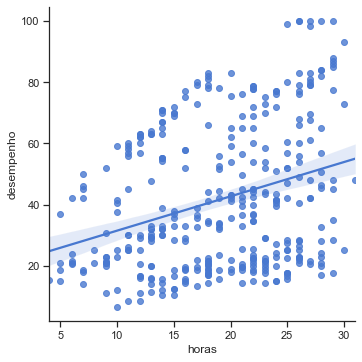

In [1324]:
#Gráfico de desempenho x horas (OLS)
sns.lmplot(x="horas", y="desempenho", data=dados)

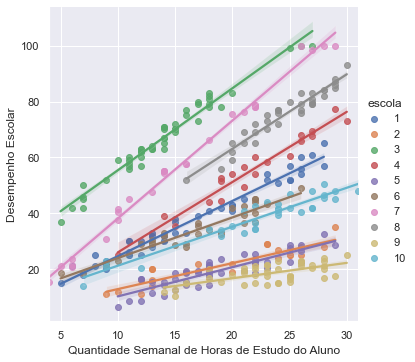

In [1325]:
#Gráfico de desempenho x horas por escola (visualização do contexto)
#NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.lmplot(x="horas", y="desempenho", hue="escola", data=dados)
ax.set(xlabel="Quantidade Semanal de Horas de Estudo do Aluno", ylabel="Desempenho Escolar")

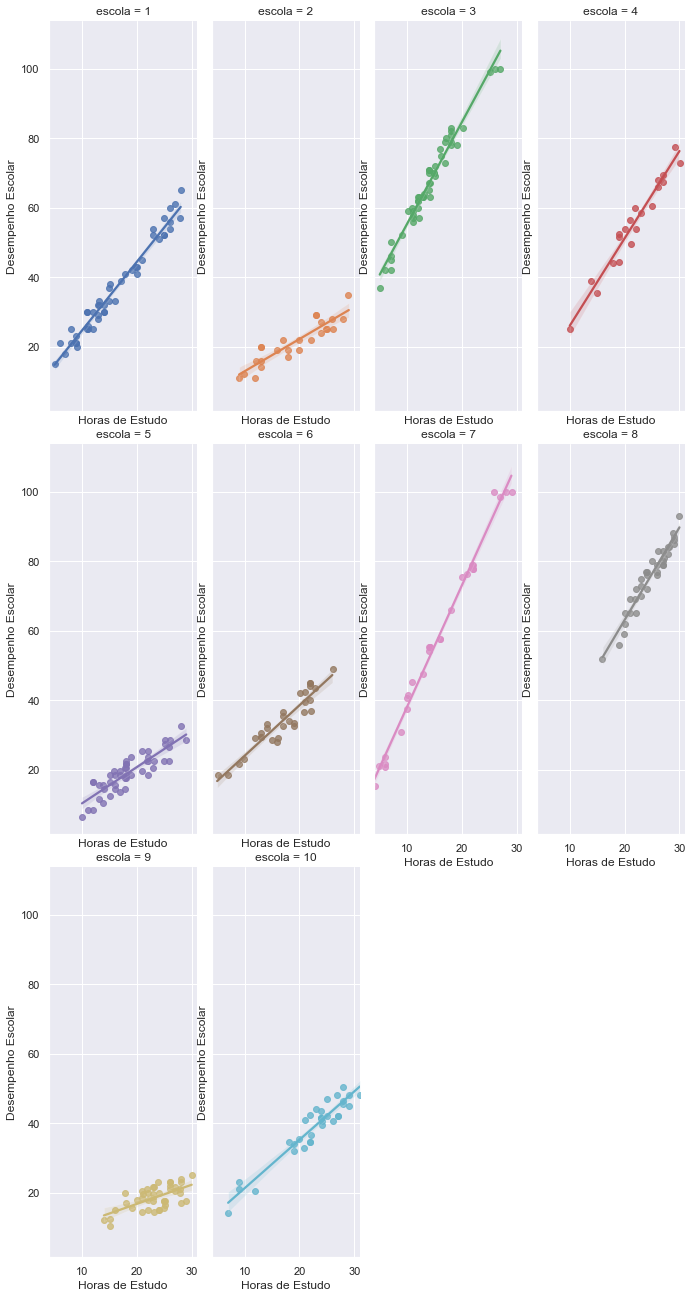

In [1249]:
#Analise de Forma individual
#Gráfico de desempenho x horas por escola (visualização do contexto)
ax = sns.lmplot(x="horas", y="desempenho", hue="escola", col="escola",
               data=dados, height=6, aspect=.4, x_jitter=.1,col_wrap=4)
ax.set(xlabel="Horas de Estudo", ylabel="Desempenho Escolar")

# Estimação do modelo nulo, apenas variação no intercepto (HML2)

### Verificar se existe diferença entre alunos  de escolas distintas?

In [1326]:
#Modelo Step-up strategy = Stepwise manualmente
# Modelo nulo nao tem variavel X , somente intercpto
#Efeitos aleatorios somente no intercpto
#Y00 = media geral da var Y = Intercpto
#v0j = Efeito aleatorio de intercpto
#Eij = erro 
# desempenho = Y00+vj0+Eij

#OBJETIVO = verificar se tem efeito aleatorio de intercpto no nivel escola

In [1327]:
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as bgmm

In [1328]:
#enc = GLMMEncoder(cols=['desempenho']).fit(x, y)
#numeric_dataset = enc.transform(x)

In [1349]:
import statsmodels.formula.api as smf
from patsy import dmatrices
formula = "desempenho ~ 1"
nivel_2 = "escola"
efeito_aleat_nulo = '~1'

md  = smf.mixedlm(formula, dados, groups=nivel_2,re_formula = efeito_aleat_nulo)
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          



In [1341]:
#Aic
aic = mdf.llf*-2.004238;aic

2838.0158252463066

In [1342]:
# Gamma00  = Y00 (intercpto)
intercpto = mdf.params.Intercept
intercpto

42.3871085309764

In [1256]:
#Variancia do v0j = Efeito aleatorio de intercpto nivel escola
print(f'Efeito aleatorio de intercpto no nivel escola: {np.array(mdf.cov_re)[0,0]}')

#Desvio padrao do Intercpto
print(f'Desvio padrao do Intercpto: {np.array(np.sqrt(mdf.cov_re))[0,0]}')

Efeito aleatorio de intercpto no nivel escola: 414.0671090661259
Desvio padrao do Intercpto: 20.34863899788204


In [1257]:
#Variancia E(erro) do efeito aleatorio do nivel individuo(nivel1)
print(f'Efeito aleatorio do nivel individuo(nivel1): {mdf.scale}')

#Desvio padrao dos Residuos
print(f'Desvio padrao dos Residuos: {np.sqrt(mdf.scale)}')

Efeito aleatorio do nivel individuo(nivel1): 142.92421239557424
Desvio padrao dos Residuos: 11.955091484199285


In [1258]:
# As 2 variancias sao significantes a 95% do nivel de confiança
mdf.pvalues

Intercept    5.641186e-11
Group Var    3.802931e-02
dtype: float64

**Quer dizer que a variancia é estatisticamente diferente de 0 (Existe significancia estatistica entre Desempenho e Escola), Modelo Multinivel é superior a qualquer modelo OLS, Caso o p_valor fosse >0.10 o loglike do modelo multinivel iria ser parecido ao loglike do OLS**

# Calculo do ICC

In [1259]:
# Calculo do ICC - Intraclass Correlation
# Calcula a variaçao explicada da y em relaçao a variavel X
#Proporçao da variancia do nivel escola em relaçao a variancia total dos termos de erro

#Formula : 
v0j = mdf.cov_re.iloc[0,0] # Efeito aleatorio de intercpto nivel escola
E = mdf.scale # Variancia E(erro) do efeito aleatorio do nivel individuo
icc = v0j /(v0j + E)
print(f'ICC= {round(icc*100)}%')


ICC= 74%


**Quer dizer que 74% da variavel Y(Desempenho) é explicada pela variavel X(Escola)**

## ESTIMAÇÃO DO MODELO NULO OLS

In [1260]:
import statsmodels.api as sm
x_interc = sm.add_constant(x) # Somente o Intercept
modelo = sm.OLS(y,x_interc[['const']]) # funçao 
resultado = modelo.fit() # Treinar o modelo
resultado.summary() # Verificar os dados do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 11 Oct 2021   Prob (F-statistic):                nan
Time:                        15:35:50   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.5542      1.228     33.852      0.000      39.140      43.968
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.903
Skew:                           0.626   Prob(JB):                     1.95e-07
Kurtosis:                       2.291   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO  

In [1261]:
#Loglike
print(f'LogLike Modelo Multinivel: {mdf.llf}')
print(f'LogLike Modelo OLS: {resultado.llf}')
print(f'Diferença entre Multinivel e OlS: {-1*(mdf.llf -resultado.llf) }')

LogLike Modelo Multinivel: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
Diferença entre Multinivel e OlS: -217.4778040206586


## Como os modelos multiniveis não conseguem selecionar as melhores variaveis para a prediçao do modelo (Step-Wise), temos que a partir da conclusão que a variavel de nivel 2 tem significancia estatistica ,fazemos Step Up(Inserir parametros aleatorios a cada estagio da modelagem)

# 1° Estagio do modelo Step Up - Modelos com Interceptos aleatórios ( Incluir a variavel horas no nivel 1)

### Existe diferença no interceptos do desempenho em funçao de horas entre alunos de escolas distintas?

In [1350]:
import statsmodels.formula.api as smf
from patsy import dmatrices
formula = "desempenho ~ horas" # Componentes de efeitos fixos
efeito_aleat_nulo = '~1'
md1  = smf.mixedlm(formula, dados, groups=dados["escola"],re_formula = efeito_aleat_nulo )
mdf1 = md1.fit()
print(mdf1.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              31.5519   
Min. group size:  20      Log-Likelihood:     -1155.2466
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.530    7.027  0.645 0.519 -9.243 18.303
horas          1.970    0.056 35.042 0.000  1.859  2.080
Group Var    481.185   40.975                           



In [1351]:
#Componente de efeitos aleatorios do intercepto da variavel Escola
intercpt_escola =  np.sqrt(mdf1.cov_re.iloc[0,0]) # Raiz 
intercpt_escola

21.935933098920817

In [1352]:
#Residuos do Componente de efeitos aleatorios do intercpto da variavel Escola
resi_escola = np.sqrt(mdf1.scale) #Raiz
resi_escola

5.6171036817044815

In [1334]:
#Estimativas de variância 
mdf1.cov_re.iloc[0,0]

481.1851609203298

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [1265]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {mdf.llf}')
print(f'LogLike Modelo OLS: {resultado.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mdf1.llf}')


LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888093


# 2° Estagio do modelo Step Up - Modelos com Interceptos e Inclinaçoes aleatórias ( Incluir a variavel horas no nivel 2)

### Existe diferença nos interceptos das equações do desempenho em função de horas e nas taxas de crescimento do desempenho em função da quantidade de horas que os alunos estudam entre alunos da mesma ou diferentes escolas?

In [1353]:
formula = "desempenho ~ horas"
incli_nivel2_horas = 'horas'
nivel_2 = "escola"
md2  = smf.mixedlm(formula, dados,re_formula= incli_nivel2_horas,groups=nivel_2)
mdf2 = md2.fit()
print(mdf2.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  desempenho
No. Observations:   358      Method:              REML      
No. Groups:         10       Scale:               7.0497    
Min. group size:    20       Log-Likelihood:      -906.8028 
Max. group size:    48       Converged:           Yes       
Mean group size:    35.8                                    
------------------------------------------------------------
                   Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           7.121    2.426 2.935 0.003  2.366 11.875
horas               1.895    0.308 6.158 0.000  1.292  2.498
escola Var         55.078   10.278                          
escola x horas Cov  2.568    0.986                          
horas Var           0.938    0.170                          



# P-value dos parametros

In [1267]:
round(mdf2.pvalues,3)

Intercept             0.003
horas                 0.000
escola Var            0.044
escola x horas Cov    0.326
horas Var             0.038
dtype: float64

**Podemos observar que tanto o intercepto quanto a inclinação são estatisticamente significantes a um nivel de 5%, porém nos modelos multinivel podemos aceitar com um nivel de significancia de 10% para os efeitos aleatorios de inclinação pois podemos não ter uma substancialidade amostral significante dentre de todos os contextos**

**Caso o p-valor da variavel 'horas' nao tivesse sido estatisticamente diferente de 0 , esse modelo nao seria estatisticamente diferente do anterior**

# Parametros das variaveis Fixas

In [1268]:
#Parametros das variaveis Fixas
mdf2.fe_params

Intercept    7.120541
horas        1.894527
dtype: float64

# Significancia estatistica dos efeitos aleatorios

In [1269]:
mdf2.cov_re

,escola,horas
escola,55.078152,2.568169
horas,2.568169,0.938029


### Intercepto

In [1357]:
round(np.sqrt(mdf2.cov_re.iloc[0,0]),3)


7.421

### Inclinação

In [1359]:
round(np.sqrt(mdf2.cov_re.iloc[1,1]),3)

0.969

### Variancia E(erro) do efeito aleatorio

In [1272]:
print(f'E(erro) do efeito aleatorio: {round(mdf2.scale,4)}')

E(erro) do efeito aleatorio: 7.0497


## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [1273]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {mdf.llf}')
print(f'LogLike Modelo OLS: {resultado.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mdf1.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : {mdf2.llf}')

LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888093
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : -906.8027522125874


**Podemos observar o ganho de LogLike quando colocamos o efeito aleatorio de inclinação**

# 3° Estagio do modelo Step Up - Modelos com Interceptos e Inclinaçoes aleatórias ( Incluir a variavel 'Texp' somento no nivel 2 ,só vai variar entre as escolas)

### Verificar se os inteceptos diferentes das equações das escolas , ocorrem em função da variavel 'Texp'(Tempo de experiencia dos professores)? e verificar se a taxa de crescimento em relaçao as horas se da em função do tempo de experiencia dos professores em cada uma das escolas?

In [1368]:
formula = "desempenho ~ horas + texp +texp*horas "
md3  = smf.mixedlm(formula, dados,re_formula= 'horas',groups="escola")
mdf3 = md3.fit()
print(mdf3.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  desempenho
No. Observations:    358      Method:              REML      
No. Groups:          10       Scale:               7.0443    
Min. group size:     20       Log-Likelihood:      -894.5684 
Max. group size:     48       Converged:           Yes       
Mean group size:     35.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.850    2.999 -0.283 0.777 -6.727  5.028
horas               0.713    0.321  2.225 0.026  0.085  1.342
texp                1.585    0.487  3.256 0.001  0.631  2.540
texp:horas          0.232    0.053  4.405 0.000  0.129  0.335
escola Var         24.345    5.167                           
escola x horas Cov -2.354    0.514                           
horas Var           

# P-value dos parametros

In [1275]:
round(mdf3.pvalues,3)

Intercept             0.777
horas                 0.026
texp                  0.001
texp:horas            0.000
escola Var            0.076
escola x horas Cov    0.084
horas Var             0.053
dtype: float64

**Podemos observar que tanto o intercepto quanto a inclinação são estatisticamente significantes a um nivel de 5%, porém nos modelos multinivel podemos aceitar com um nivel de significancia de 10% para os efeitos aleatorios de inclinação pois podemos não ter uma substancialidade amostral significante dentre de todos os contextos**

**Caso o p-valor da variavel 'texp' nao tivesse sido estatisticamente diferente de 0 , esse modelo nao seria estatisticamente diferente do anterior**

# Significancia estatistica dos efeitos aleatorios

In [1276]:
mdf3.cov_re

,escola,horas
escola,24.345360,-2.353553
horas,-2.353553,0.305278


### Intercepto

In [1369]:
round(np.sqrt(mdf3.cov_re.iloc[0,0]),3)

4.934

### Inclinação

In [1370]:
round(np.sqrt(mdf3.cov_re.iloc[1,1]),3)

0.553

### Variancia E(erro) do efeito aleatorio

In [1372]:
print(f'E(erro) do efeito aleatorio: {round(np.sqrt(mdf3.scale),4)}')

E(erro) do efeito aleatorio: 2.6541


## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

In [1280]:
#Loglike
print(f'LogLike Modelo HLM2 Nulo: {mdf.llf}')
print(f'LogLike Modelo OLS: {resultado.llf}')
print(f'LogLike Modelo HLM2 com Intercepto Aleatorio: {mdf1.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : {mdf2.llf}')
print(f'LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias +Var texp : {mdf3.llf}')

LogLike Modelo HLM2 Nulo: -1416.0073929574764
LogLike Modelo OLS: -1633.485196978135
LogLike Modelo HLM2 com Intercepto Aleatorio: -1155.2466403888093
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias : -906.8027522125874
LogLike Modelo HLM2 com Intercepto e Inclinações Aleatorias +Var texp : -894.568407853362


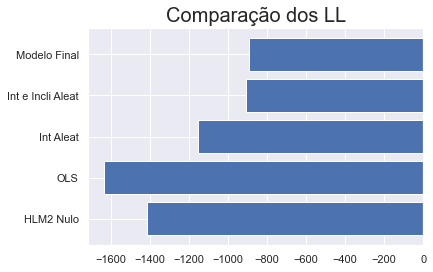

In [1281]:
a = ['HLM2 Nulo','OLS','Int Aleat','Int e Incli Aleat','Modelo Final']
b = [mdf.llf,resultado.llf,mdf1.llf,mdf2.llf,mdf3.llf]
plt.barh(a,b);
plt.title('Comparação dos LL',size=20);

**Podemos observar que o LL do modelo Final com a var texp e o modelo com Intercepto e Inclinações Aleatorias obtiveram os melhores LL , isso porque a var texp neste contexto não fez muita diferença , apesar do LL ser o melhor**

## Visualização dos interceptos e das inclinações aleatórios por escola

In [1282]:
int_incli = pd.DataFrame(mdf3.random_effects).T
int_incli

,escola,horas
1,-0.211364,0.438811
2,1.291495,-0.278181
3,6.090772,-0.779130
4,-5.245506,0.450368
5,-1.695358,-0.139678
6,3.864292,0.005096
7,-8.270892,0.909171
8,-1.363471,0.217166
9,3.705674,-0.607100
10,1.834358,-0.216522


**Intercepto da Escola e o valor da inclinaçao a cada incremento de 1 unidade de estudo**

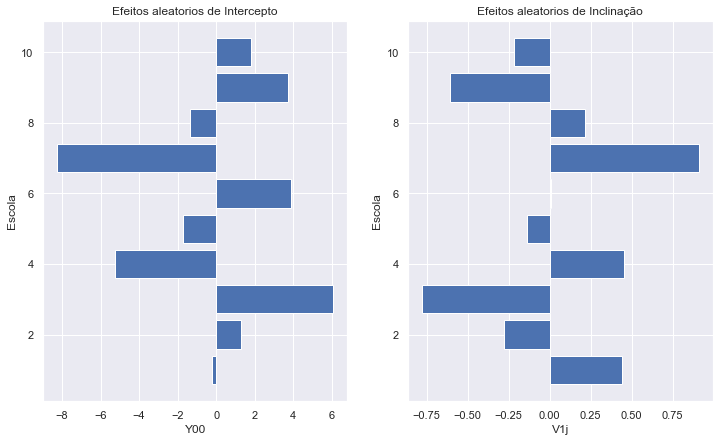

In [1283]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
a = np.arange(len(aa))+1
b = int_incli.escola
ax1.barh(a,b);
ax1.set(title="Efeitos aleatorios de Intercepto", xlabel="Y00", ylabel="Escola")
plt.gca().invert_yaxis()


a1 = np.arange(len(aa))+1
b1 = int_incli.horas
ax2.barh(a1,b1);
ax2.set(title="Efeitos aleatorios de Inclinação", xlabel="V1j", ylabel="Escola")

plt.gca().invert_yaxis()

# Previsão

In [1284]:
#Selecionar as variaveis Preditoras
x_pred= x.iloc[:,1:]
x_pred

,escola,horas,texp
0,1,11,3.6
1,1,23,3.6
2,1,25,3.6
3,1,14,3.6
4,1,24,3.6
...,...,...,...
353,10,28,3.9
354,10,9,3.9
355,10,27,3.9
356,10,7,3.9


In [1285]:
dados_final = x_prev.set_index('escola')
dados_final

,horas,texp,predict.fixed
escola,,,
1,11,3.6,21.885819
1,23,3.6,40.462363
1,25,3.6,43.558453
1,14,3.6,26.529955
1,24,3.6,42.010408
...,...,...,...
10,28,3.9,50.625529
10,9,3.9,19.891243
10,27,3.9,49.007935


In [1286]:
dados_final['Intercepto'] = int_incli.escola
dados_final['Inclinaçao'] = int_incli.horas
dados_final

,horas,texp,predict.fixed,Intercepto,Inclinaçao
escola,,,,,
1,11,3.6,21.885819,-0.211364,0.438811
1,23,3.6,40.462363,-0.211364,0.438811
1,25,3.6,43.558453,-0.211364,0.438811
1,14,3.6,26.529955,-0.211364,0.438811
1,24,3.6,42.010408,-0.211364,0.438811
...,...,...,...,...,...
10,28,3.9,50.625529,1.834358,-0.216522
10,9,3.9,19.891243,1.834358,-0.216522
10,27,3.9,49.007935,1.834358,-0.216522


# Previsão com os efeitos fixos

In [1287]:
x_prev['predict.fixed'] = mdf3.predict(exog=x_prev)
x_prev = x_prev.iloc[:,0:4];x_prev

,escola,horas,texp,predict.fixed
0,1,11,3.6,21.885819
1,1,23,3.6,40.462363
2,1,25,3.6,43.558453
3,1,14,3.6,26.529955
4,1,24,3.6,42.010408
...,...,...,...,...
353,10,28,3.9,50.625529
354,10,9,3.9,19.891243
355,10,27,3.9,49.007935
356,10,7,3.9,16.656055


In [1288]:
# Previsao com os Efeitos Fixos + Efeitos Aleatorios Escola de cada aluno

In [1289]:
dados_final['predict.aleat'] = dados_final['predict.fixed']+dados_final['Intercepto']+dados_final['Inclinaçao']*dados_final['horas']
dados_final = dados_final.reset_index()
dados_final['Desempenho']=dados.desempenho
dados_final

,escola,horas,texp,predict.fixed,Intercepto,Inclinaçao,predict.aleat,Desempenho
0,1,11,3.6,21.885819,-0.211364,0.438811,26.501371,25.0
1,1,23,3.6,40.462363,-0.211364,0.438811,50.343641,52.0
2,1,25,3.6,43.558453,-0.211364,0.438811,54.317353,52.0
3,1,14,3.6,26.529955,-0.211364,0.438811,32.461938,30.0
4,1,24,3.6,42.010408,-0.211364,0.438811,52.330497,51.0
...,...,...,...,...,...,...,...,...
353,10,28,3.9,50.625529,1.834358,-0.216522,46.397262,46.5
354,10,9,3.9,19.891243,1.834358,-0.216522,19.776900,21.0
355,10,27,3.9,49.007935,1.834358,-0.216522,44.996191,42.0
356,10,7,3.9,16.656055,1.834358,-0.216522,16.974757,14.0


## Somente as veriaveis Targets por escola

In [1290]:
target = dados_final[['escola','Desempenho','predict.fixed','predict.aleat']]
target

,escola,Desempenho,predict.fixed,predict.aleat
0,1,25.0,21.885819,26.501371
1,1,52.0,40.462363,50.343641
2,1,52.0,43.558453,54.317353
3,1,30.0,26.529955,32.461938
4,1,51.0,42.010408,52.330497
...,...,...,...,...
353,10,46.5,50.625529,46.397262
354,10,21.0,19.891243,19.776900
355,10,42.0,49.007935,44.996191
356,10,14.0,16.656055,16.974757


## Previsão sem o uso do algoritimo 

### Prever linha 0

In [1291]:
linha_zero = dados[['escola','horas','texp']]
linha_zero.head(1)


,escola,horas,texp
0,1,11,3.6


### Parametros Efeitos Fixos

In [1292]:
parm_fixed =pd.DataFrame(mdf3.params,columns=['Parametros_fixos'])
parm_fixed

,Parametros_fixos
Intercept,-0.849603
horas,0.713461
texp,1.585256
texp:horas,0.231829
escola Var,3.456013
escola x horas Cov,-0.334105
horas Var,0.043337


In [1293]:
#Atribuindo os parametros nas variaveis
intercepto_fixed = mdf3.params.Intercept
horas_fixed = mdf3.params.horas
texp_fixed = mdf3.params.texp
texp_horas_fixed = mdf3.params[3]

print(f'horas_fixed: {horas_fixed}')
print(f'texp_fixed: {texp_fixed}')
print(f'texp_horas_fixed {texp_horas_fixed}')

horas_fixed: 0.7134611038732946
texp_fixed: 1.5852563538778488
texp_horas_fixed 0.2318289476392338


## Previsão: Parametros Fixos

In [1294]:
#Variaveis Preditoras
escola = 1.0
horas = 11.0
texp = 3.6

#Previsão Parametros Fixos
fixed = intercepto_fixed + horas_fixed*horas + texp_fixed*texp + texp_horas_fixed*(texp*horas)
fixed

21.885818777437756

## Previsão: Parametros Fixos + Aleatorios

### Parametros Efeitos Aleatorios

In [1295]:
int_incli = pd.DataFrame(mdf3.random_effects).T
int_incli.head(1)

,escola,horas
1,-0.211364,0.438811


In [1296]:
#Atribuindo os parametros nas variaveis
intercepto_alet = int_incli.iloc[0,0]
inclinacao_alet = int_incli.iloc[0,1]

print(f'intercepto_alet: {intercepto_alet}')
print(f'inclinacao_alet: {inclinacao_alet}')


intercepto_alet: -0.21136442177602
inclinacao_alet: 0.4388105800486315


In [1297]:
#Variaveis Preditoras
horas = 11.0

#Previsão
fixed_alet = fixed + intercepto_alet + inclinacao_alet*horas
fixed_alet

26.501370736196684

# Comparar as Predições com os Efeitos Fixos e Efeitos Fixos + Aleatorios

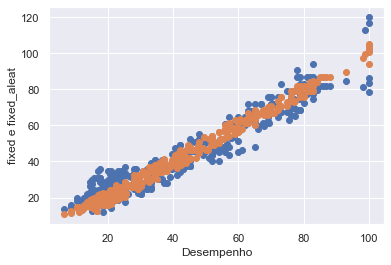

In [1298]:
plt.scatter(target.Desempenho,target['predict.fixed']);
plt.scatter(target.Desempenho,target['predict.aleat']);
plt.xlabel('Desempenho');
plt.ylabel('fixed e fixed_aleat');



**Note que as variaveis de efeitos fixos + Aleatorios se ajustão bem mais dos que somente as variaveis de efeitos fixos**

# COMPARAÇÃO COM UM MODELO OLS COM DUMMIES 

In [1299]:
Dummies = pd.get_dummies(dados['escola'])
Dummies = Dummies.iloc[:,1:10]#Excluir a 1 variaveis para que ela seja referencia no modelo , e excluir a var 10 que nao tem diferença estatisticamente significante
Dummies.head(3)# cada numero do titulo variavel represente o numero da escola 

,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0


In [1300]:
#Juntar as dataframes
x1 = x[['horas','texp']]
dados1 = x1.join(Dummies)
dados1.head(3)

,horas,texp,2,3,4,5,6,7,8,9,10
0,11,3.6,0,0,0,0,0,0,0,0,0
1,23,3.6,0,0,0,0,0,0,0,0,0
2,25,3.6,0,0,0,0,0,0,0,0,0


In [1301]:
#Modelo OLS
import statsmodels.api as sm
x_constante = sm.add_constant(dados1)
y = dados['desempenho'].values
modelo = sm.OLS(y,x_constante)
modelo_v1 = modelo.fit()
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     575.7
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          2.81e-209
Time:                        15:36:03   Log-Likelihood:                -1120.2
No. Observations:                 358   AIC:                             2262.
Df Residuals:                     347   BIC:                             2305.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0528      1.352     -8.175      0.000     -13.712      -8.394
horas          1.9713      0.056     35.063      0.000       1.861       2.082
texp           4.4516      0.096     46.582      0.000       4.264       4.640
2            -14.6664      1.452    -10.101      0.000     -17.522     -11.811
3             -7.2914      0.685    -10.651      0.000      -8.638      -5.945
4             -0.7854      1.443     -0.544      0.587      -3.624       2.053
5            -14.8095      1.238    -11.967      0.000     -17.244     -12.375
6             -3.3658      1.321     -2.548      0.011      -5.964      -0.768
7              2.3462      1.115      2.103      0.036       0.152       4.540
8              4.5433      1.130      4.021      0.000       2.321       6.766
9            -24.6820      1.323    -18.657      0.000     -27.284     -22.080
10           -11.9232      1.310     -9.099      0.000     -14.501      -9.346
==============================================================================
Omnibus:                       14.171   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.665
Skew:                           0.002   Prob(JB):                     8.07e-08
Kurtosis:                       4.480   Cond. No.                     7.10e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.02e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1302]:
#Excluir a var 10 que nao tem diferença estatisticamente significante no comportamento no desempenho em relaçao a escola 1(referencia)
dados_2 = x_constante.drop(columns=[10])

In [1303]:
#Modelo OLS (excluida variavel de escola 10)
import statsmodels.api as sm
x_constante = sm.add_constant(dados_2)
y = dados['desempenho'].values
modelo = sm.OLS(y,x_constante)
modelo_v1 = modelo.fit()
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     575.7
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          2.81e-209
Time:                        15:36:03   Log-Likelihood:                -1120.2
No. Observations:                 358   AIC:                             2262.
Df Residuals:                     347   BIC:                             2305.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.0258     16.196      8.152      0.000     100.172     163.880
horas          1.9713      0.056     35.063      0.000       1.861       2.082
texp         -35.2925      4.413     -7.997      0.000     -43.972     -26.613
2            -74.2824      7.287    -10.194      0.000     -88.614     -59.950
3            366.3026     41.021      8.930      0.000     285.621     446.984
4             74.7283      7.922      9.433      0.000      59.148      90.309
5            -82.3744      8.112    -10.155      0.000     -98.328     -66.420
6            -11.3146      1.849     -6.120      0.000     -14.951      -7.678
7            177.2200     18.960      9.347      0.000     139.928     214.512
8            159.5451     16.618      9.601      0.000     126.860     192.230
9            -92.2469      8.188    -11.266      0.000    -108.352     -76.142
==============================================================================
Omnibus:                       14.171   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.665
Skew:                           0.002   Prob(JB):                     8.07e-08
Kurtosis:                       4.480   Cond. No.                     3.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Note que todas as variaveis agora tem significancia estatistica**

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

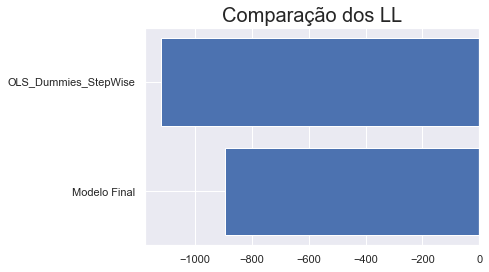

In [1304]:
a = ['Modelo Final','OLS_Dummies_StepWise']
b = [mdf3.llf,modelo_v1.llf]
plt.barh(a,b);
plt.title('Comparação dos LL',size=20);

**Conclusão: Modelo OLS X Modelo Multinivel tem uma grande diferença nas predição , porém ,caso o efeito aleatorio de inclinação no nivel 2 do modelo multinivel não se mostrar estatisticamente significantes o LL dos 2 modelos serão muito parecidos**

## Grafico dos fitted values dos modelos HLM2 Final, OLS

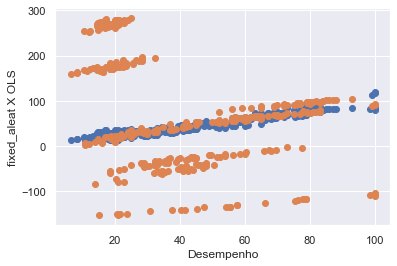

In [1305]:
plt.scatter(target.Desempenho,target['predict.fixed']);
plt.scatter(target.Desempenho,modelo_v1.predict(dados2));
plt.xlabel('Desempenho');
plt.ylabel('fixed_aleat X OLS');

# MODELO OLS COM DUMMIES + Interação entre as variaveis Horas e texp

In [1306]:
dados3=dados1
dados3['texp_horas'] = dados1.texp*dados1.horas #Interaçao entre as variaveis horas e texp
dados3.head(3)

,horas,texp,2,3,4,5,6,7,8,9,10,texp_horas
0,11,3.6,0,0,0,0,0,0,0,0,0,39.6
1,23,3.6,0,0,0,0,0,0,0,0,0,82.8
2,25,3.6,0,0,0,0,0,0,0,0,0,90.0


In [1307]:
#Modelo OLS
import statsmodels.api as sm
x_constante = sm.add_constant(dados3)
y = dados['desempenho'].values
modelo2 = sm.OLS(y,x_constante)
modelo_v2 = modelo2.fit()
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1134.
Date:                Mon, 11 Oct 2021   Prob (F-statistic):          8.66e-264
Time:                        15:36:06   Log-Likelihood:                -986.91
No. Observations:                 358   AIC:                             1998.
Df Residuals:                     346   BIC:                             2044.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5565      1.261      4.405      0.000       3.075       8.038
horas          0.8306      0.070     11.859      0.000       0.693       0.968
texp           1.3486      0.172      7.851      0.000       1.011       1.686
2            -11.8836      1.012    -11.743      0.000     -13.874      -9.893
3             -8.2138      0.475    -17.301      0.000      -9.148      -7.280
4             -2.2088      0.999     -2.212      0.028      -4.173      -0.245
5            -12.1903      0.864    -14.102      0.000     -13.890     -10.490
6             -2.9843      0.912     -3.273      0.001      -4.778      -1.191
7              0.5424      0.775      0.700      0.485      -0.982       2.067
8             -1.9272      0.847     -2.275      0.023      -3.593      -0.261
9            -18.7334      0.962    -19.469      0.000     -20.626     -16.841
10           -10.3706      0.908    -11.424      0.000     -12.156      -8.585
texp_horas     0.2232      0.011     19.563      0.000       0.201       0.246
==============================================================================
Omnibus:                       18.488   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.104
Skew:                          -0.278   Prob(JB):                     1.45e-08
Kurtosis:                       4.453   Cond. No.                     3.95e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  3e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## COMPARAÇÃO DOS LLs DE TODOS OS MODELOS 

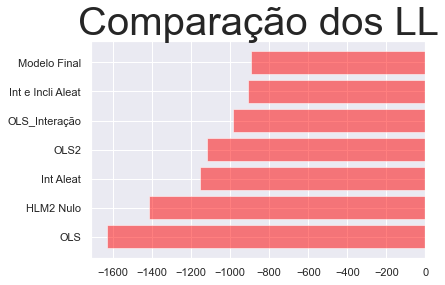

In [1309]:
#Criar um dataFrame com os LLs
a = ['HLM2 Nulo','OLS','Int Aleat','Int e Incli Aleat','Modelo Final','OLS2','OLS_Interação']
b = [mdf.llf,resultado.llf,mdf1.llf,mdf2.llf,mdf3.llf,modelo_v1.llf,modelo_v2.llf]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

**Conclusão: Podemos observar que o Modelo Final tem o melhor LL**